In [76]:
#IMPORT THE LIBRARIES

import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import soundfile

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from glob import glob #glob helps us list all the files in directory
import os, glob, pickle

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Load CSV file
# Question: Where did this CSV file come from? I thought it only
# audio file we're working on.
RAVD = pd.read_csv('/Users/jennyskytta/Downloads/features.csv')
RAVD.shape #Dataset 1 to be combined 

# (4320, 21)

(4320, 21)

In [3]:
# Show first 5 rows of dataset
RAVD.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-637.701233,104.299019,4.894947,20.494011,12.552954,2.851410,-6.633390,-4.091278,-10.423918,-6.406950,...,0.172893,-1.170210,-5.292450,-0.573319,1.019471,-3.492607,-3.468123,-1.214944,1.971239,male_calm
1,-596.908460,86.871936,9.470162,17.109819,11.198966,1.541056,-6.677264,-5.755428,-9.684472,-6.891256,...,0.033803,-1.986515,-5.103855,-1.253110,0.514896,-3.268317,-4.502895,0.167153,0.256732,male_calm
2,-698.086548,99.795929,1.892679,19.915264,7.532868,1.265761,-9.188656,-5.798194,-12.299710,-4.976400,...,-1.639542,-2.603761,-4.890347,-0.879222,-1.250208,-3.449960,-4.708529,-0.086224,-3.034044,male_calm
3,-279.141052,41.092949,-21.319229,7.802911,-13.140503,-9.407660,-15.580647,-6.097223,-24.700903,-9.640293,...,-10.305976,-4.092835,-5.817179,-10.731523,-0.823596,-15.885103,-2.014258,-6.173852,-5.331760,male_angry
4,-160.074686,17.576058,-2.147436,3.133417,-4.745002,-6.510771,-5.911591,-4.481506,-9.470598,-5.907823,...,-4.088007,-1.817639,-2.994765,-4.893176,-2.880436,-7.163400,-2.147345,-2.359248,-3.746217,male_angry


In [5]:
# Get all pathnames for sound files in sound dataset
# Note: Not sure if this code chunk is relevant to the Analysis,
# consider removing.
speech = glob.glob('/Users/jennyskytta/Downloads/speech//Actor_*//*.wav')

In [6]:
# Get total count of values in "labels" column
RAVD.labels.count

# Suggestion: try adding showing all unique values in "labels" so 
# reader see how many unique values there are.
RAVD.labels.unique()

array(['male_calm', 'male_angry', 'male_fear', 'male_neutral', 'male_sad',
       'male_happy', 'male_surprise', 'male_disgust', 'female_calm',
       'female_angry', 'female_happy', 'female_neutral', 'female_sad',
       'female_surprise', 'female_disgust', 'female_fear'], dtype=object)

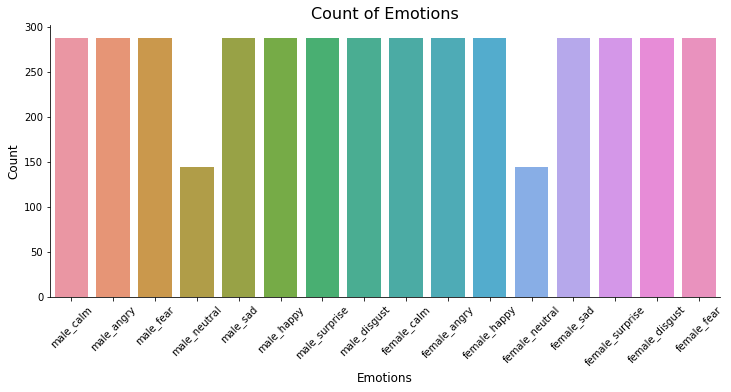

In [7]:
# Plot the total count of each unique values (emotions by gender)
# in the "labels" column.
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAVD.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [8]:
# Female Happy
# Play audio of happy female
fRA1= '/Users/jennyskytta/Downloads/speech/Actor_08/03-01-03-02-02-01-08.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1) 

The two basic attributes of sound are amplitude (what we also call loudness) and frequency (a measure of the wave’s vibrations per time unit).  Sound must be converted from analog into digital via sampling and quantization.  Sampling is used to convert the time-varying continuous signal x(t) to a discrete sequence of real numbers x(n). The interval between two successive discrete samples is the sampling period (Ts). We use the sampling frequency (fs = 1/Ts) as the attribute that describes the sampling process. Quantization is reducing the infinite number of audio samples to a finite number quantified as number of bits.

In [47]:
# Showing shape of y as array representation of sample rate of Female Happy wav file
y , sr = librosa.load(fRA1)
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [8.7765067e-05 9.9243996e-05 9.0145193e-05 8.6895241e-05 6.6300810e-05
 5.4724176e-05 6.4786880e-05 6.0458053e-05 5.8111178e-05 6.8182686e-05]
shape y: (84610,)
sr: 22050


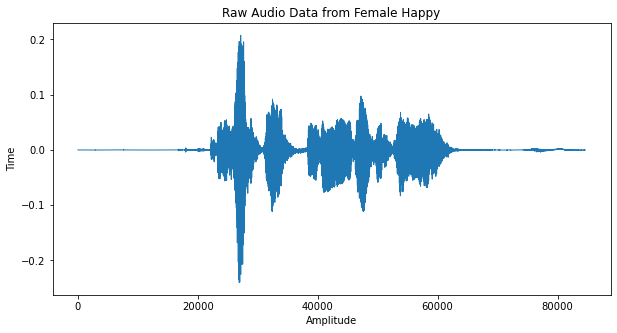

In [16]:
# Create waveform plot to visualize the the sound (time vs amplitude)
# Note: consider adding x & y lables (time(ms) & amplitude)

pd.Series(y).plot(figsize=(10,5), #converted numpy array to pandas series as series are easier to plot than numpy arrays
                 lw =1,
                 title = 'Raw Audio Data from Female Happy')
plt.ylabel("Time")
plt.xlabel("Amplitude")
plt.show()

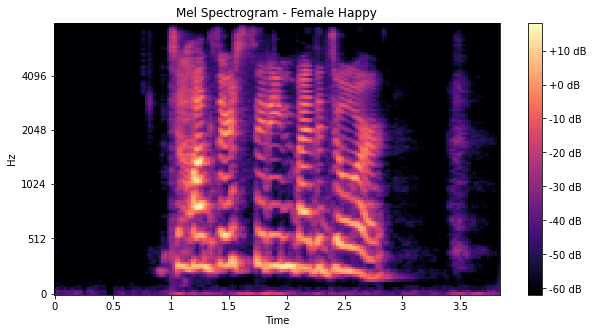

In [17]:
# CREATE LOG MEL SPECTROGRAM to show frequency of sound waves

plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Happy')
plt.colorbar(format='%+2.0f dB')
#add this code
plt.show()

In [18]:
#Female Fear
# Play audio of fearful female

fRA2='/Users/jennyskytta/Downloads/speech/Actor_08/03-01-06-01-01-01-08.wav'
data, sr = librosa.load(fRA2)
ipd.Audio(fRA2) 

In [19]:
# Showing shape of y as array representation of sample rate of Female Fearful wav file
y , sr = librosa.load(fRA2)
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [ 2.8520324e-05  1.1931472e-05 -7.9743577e-06  3.8964895e-06
  2.9264665e-05  3.6952879e-05  1.7455874e-05  4.6079455e-07
  2.1372211e-05  4.2544663e-05]
shape y: (87553,)
sr: 22050


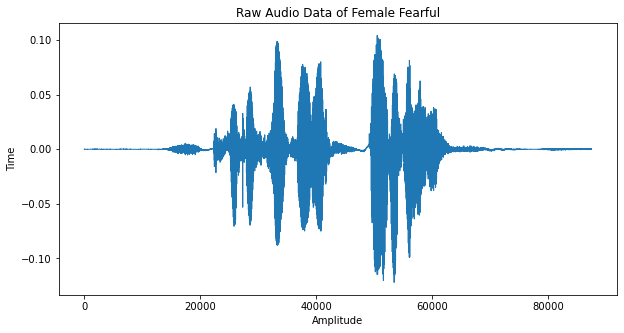

In [22]:
# Create waveform plot to visualize the the sound (time vs amplitude)

pd.Series(y).plot(figsize=(10,5), #converted numpy array to pandas series as series are easier to plot than numpy arrays
                 lw =1,
                 title = 'Raw Audio Data of Female Fearful')
plt.ylabel("Time")
plt.xlabel("Amplitude")

plt.show()

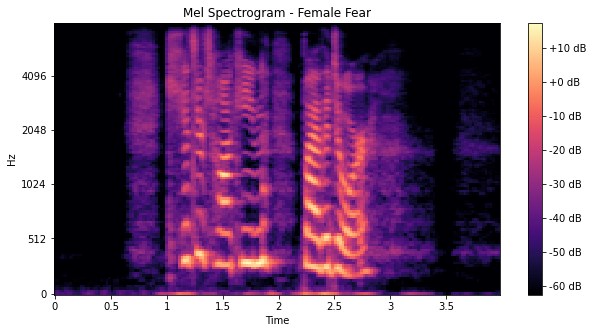

In [23]:
# CREATE LOG MEL SPECTROGRAM to show frequency of sound waves
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Fear')
plt.colorbar(format='%+2.0f dB');

In [24]:
# Female Disgust
# Play audio of female in disgust

fRA3 ='/Users/jennyskytta/Downloads/speech/Actor_20/03-01-08-02-02-02-20.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA3) 

In [26]:
# Showing shape of y as array representation of sample rate of Female Disgust wav file
y , sr = librosa.load(fRA3)
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
shape y: (75781,)
sr: 22050


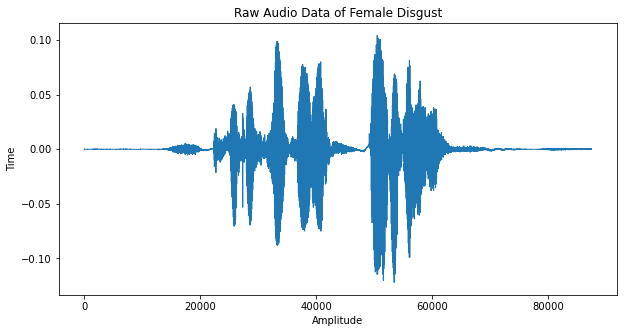

In [25]:
# Create waveform plot to visualize the the sound (time vs amplitude)
# Note: consider adding x & y lables (time(ms) & amplitude)

pd.Series(y).plot(figsize=(10,5), #converted numpy array to pandas series as series are easier to plot than numpy arrays
                 lw =1,
                 title = 'Raw Audio Data of Female Disgust')
plt.ylabel("Time")
plt.xlabel("Amplitude")

plt.show()

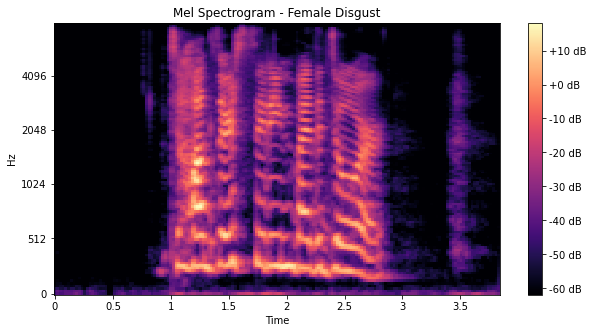

In [27]:
# CREATE LOG MEL SPECTROGRAM to show frequency of sound waves

plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Disgust')
plt.colorbar(format='%+2.0f dB');

In [28]:
# Male Fearful
# Play audio of fearful male

fRA4 = '/Users/jennyskytta/Downloads/speech/Actor_19/03-01-04-01-02-01-19.wav'
data, sr = librosa.load(fRA4)
ipd.Audio(fRA4) 

In [29]:
# Showing shape of y as array representation of sample rate of Male Fearful wav file
y , sr = librosa.load(fRA4)
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [0.00012043 0.00013551 0.00010836 0.00013098 0.0001532  0.00013289
 0.00012003 0.00012026 0.00012094 0.00014001]
shape y: (69895,)
sr: 22050


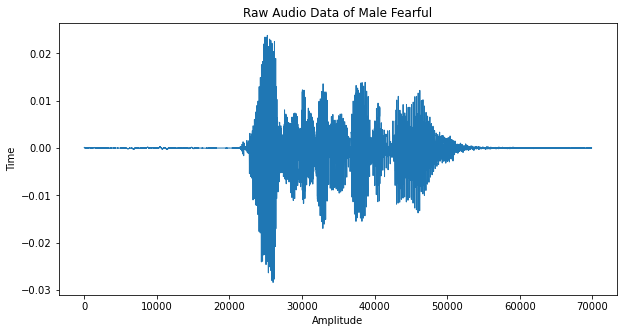

In [30]:
# Create waveform plot to visualize the the sound (time vs amplitude)
# Note: consider adding x & y lables (time(ms) & amplitude)

pd.Series(y).plot(figsize=(10,5), #converted numpy array to pandas series as series are easier to plot than numpy arrays
                 lw =1,
                 title = 'Raw Audio Data of Male Fearful')
plt.ylabel("Time")
plt.xlabel("Amplitude")

plt.show()

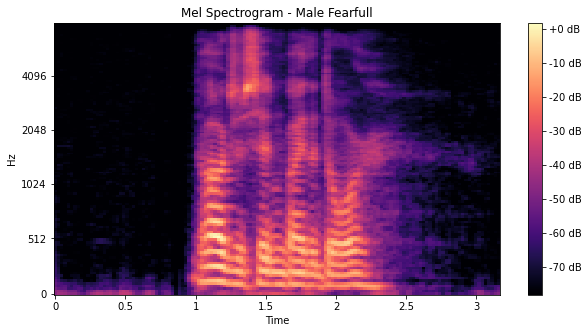

In [31]:
# CREATE LOG MEL SPECTROGRAM to show frequency of sound waves

plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Fearfull')
plt.colorbar(format='%+2.0f dB');

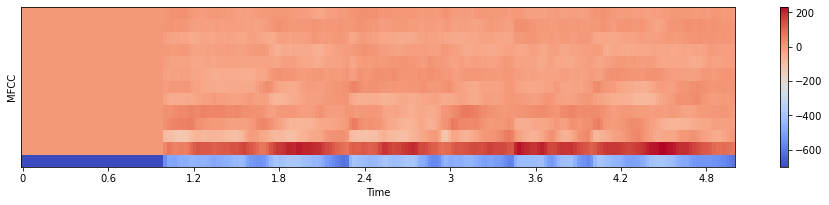

In [32]:
# Gender - Female; Emotion - Angry 
# Play audio of angry female

path = "/Users/jennyskytta/Downloads/speech/Actor_18/03-01-05-01-01-01-18.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# Plot MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

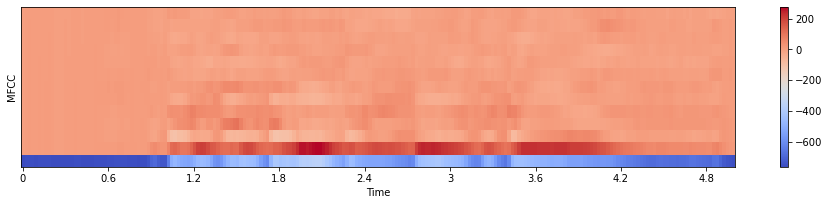

In [33]:
# Gender - Male; Emotion - Angry 
# Play audio of angry male

path = "/Users/jennyskytta/Downloads/speech/Actor_17/03-01-05-01-01-02-17.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# Plot MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

## Preparing / Reshaping Data

In [34]:
RAVD.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
3780,-581.376099,66.345596,-0.963100,7.265053,-1.178906,-6.833580,-13.369257,-8.517822,-10.809193,-0.740833,...,-10.795315,-0.326263,-6.599926,0.803155,-8.898965,-7.012513,-2.961756,-9.922439,-4.746636,female_calm
2019,-438.013519,69.919304,-25.491394,8.429243,-5.093143,-12.947881,-18.356758,-18.380085,-7.296838,4.044850,...,-4.598725,-8.634526,-6.506742,-7.629087,-10.100922,-7.142870,-1.912230,-6.186758,-0.424138,female_disgust
3268,-492.109844,26.901268,18.138603,16.948394,6.489996,3.546663,-0.884164,-6.538726,-7.965463,-3.296596,...,-4.054247,-2.294949,-1.505505,-1.060689,-0.805228,-2.617615,-0.015733,1.309937,-1.792047,male_calm
3536,-674.704834,52.795979,0.532697,-0.127147,-10.022582,-4.234118,-17.624075,-14.172759,-7.710999,-7.062942,...,-5.837801,-3.882437,-4.954323,-8.230749,-8.634475,-7.633637,-6.074372,-9.856391,-6.862522,female_disgust
554,-720.936279,53.636776,-9.168024,1.370211,-8.212382,-7.479963,-16.654932,-20.006340,-10.718909,-5.539442,...,-12.047295,-6.796594,-3.588471,-13.190588,-6.698795,-5.528731,-6.792405,-7.562801,-1.237542,female_neutral


In [35]:
X = RAVD.iloc[: ,:-1].values
Y = RAVD['labels'].values

In [36]:
# As this is a multiclass classification problem onehotencoding our Y
# Question: What does this code do to the Y variable?
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [48]:
# Train and Test Split 

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 16), (1080, 20), (1080, 16))

In [49]:
# scaling our data with sklearn's Standard scaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 16), (1080, 20), (1080, 16))

## IMPLOYING MODELS 

### Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

clf3 = DecisionTreeClassifier()

clf3 = clf3.fit(x_train,y_train)

y_pred = clf3.predict(x_test)

In [52]:
print("Training set score: {:.3f}".format(clf3.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf3.score(x_test, y_test)))

Training set score: 1.000
Test set score: 0.388


In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.33      0.32        66
           1       0.52      0.49      0.51        79
           2       0.29      0.28      0.28        71
           3       0.42      0.51      0.46        67
           4       0.43      0.32      0.37        82
           5       0.40      0.44      0.41        39
           6       0.35      0.37      0.36        75
           7       0.44      0.46      0.45        70
           8       0.41      0.32      0.36        74
           9       0.48      0.49      0.49        67
          10       0.37      0.36      0.37        66
          11       0.37      0.31      0.34        80
          12       0.42      0.41      0.41        78
          13       0.29      0.33      0.31        30
          14       0.39      0.38      0.38        72
          15       0.31      0.41      0.35        64

   micro avg       0.39      0.39      0.39      1080
   macro avg       0.39   

#### After Using the decision tree model in our dataset then the model goes in overfitting he gave accuracy around .39

## KNN

In [54]:
from sklearn.neighbors import KNeighborsClassifier

clf1=KNeighborsClassifier(n_neighbors=4)
clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=4)

In [55]:
# Make predictions
_pred=clf1.predict(x_test)

# show some predicted values
_pred[:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [56]:
# Show accuracy score for Training & Test data
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.637
Test set score: 0.449


In [57]:
print(classification_report(y_test, _pred))

              precision    recall  f1-score   support

           0       0.90      0.39      0.55        66
           1       0.86      0.63      0.73        79
           2       0.88      0.32      0.47        71
           3       0.85      0.58      0.69        67
           4       0.97      0.34      0.50        82
           5       0.72      0.46      0.56        39
           6       0.78      0.24      0.37        75
           7       0.86      0.54      0.67        70
           8       0.93      0.54      0.68        74
           9       0.87      0.70      0.78        67
          10       0.93      0.42      0.58        66
          11       0.93      0.35      0.51        80
          12       0.97      0.40      0.56        78
          13       0.88      0.23      0.37        30
          14       0.83      0.40      0.54        72
          15       0.95      0.55      0.69        64

   micro avg       0.88      0.45      0.60      1080
   macro avg       0.88   

#### Using KNN in our dataset the overall training is quite good but not for deployment and test accuracy has .45

## MLP CLASSIFIER with reduced set of emotions

In [58]:
from sklearn.neural_network import MLPClassifier

# Extract features (mfcc, chroma, mel) from a sound file

def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        return result

In [59]:
# Define dictionary to hold emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Define list for Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [60]:
# Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/Users/jennyskytta/Downloads/speech//Actor_*//*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [61]:
# Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [62]:
# Get the shape of the training and testing datasets

print((x_train.shape[0], x_test.shape[0]))

(576, 192)


In [63]:
# Get the number of features extracted

print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [64]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [65]:
# Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [66]:
# Predict for the test set
y_pred=model.predict(x_test)

# Show predictions
y_pred[:20]

array(['calm', 'fearful', 'disgust', 'calm', 'disgust', 'fearful', 'calm',
       'happy', 'disgust', 'calm', 'happy', 'happy', 'disgust', 'calm',
       'happy', 'disgust', 'fearful', 'happy', 'disgust', 'disgust'],
      dtype='<U7')

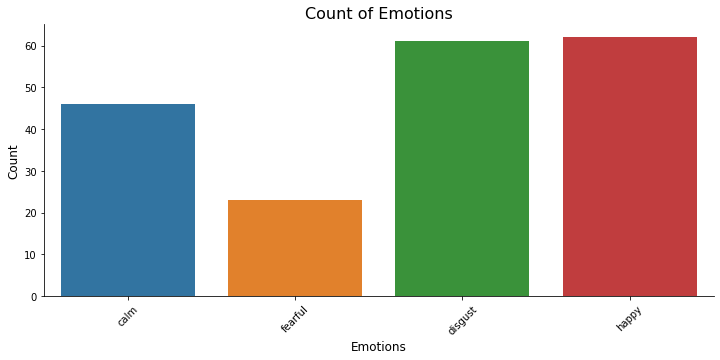

In [67]:
# Plot the total counts of predicted values
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(y_pred)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [68]:
# Get accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
#- Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 64.58%


## MLP Classifier with all emotions 

In [69]:
# Define dictionary to hold emotions in the RAVDESS dataset
# Note: sure if we need to define this distionary again since it has
# been defined. Consider deleting.
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [70]:
# Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/Users/jennyskytta/Downloads/speech//Actor_*//*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [71]:
# Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)
# Get the shape of the training and testing datasets
((x_train.shape[0], x_test.shape[0]))
(f'Features extracted: {x_train.shape[1]}')

'Features extracted: 180'

In [72]:
# Initialize the Multi Layer Perceptron Classifier
# Note: Should we consider adding more hidden layers & nodes to increase accuracy & do a confusion matrix?
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [73]:
# Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [74]:
# Predict for the test set
y_pred=model.predict(x_test)

# Show predictions
y_pred[:20]

array(['angry', 'calm', 'surprised', 'disgust', 'fearful', 'calm',
       'angry', 'surprised', 'calm', 'fearful', 'calm', 'fearful',
       'angry', 'angry', 'calm', 'surprised', 'disgust', 'surprised',
       'angry', 'angry'], dtype='<U9')

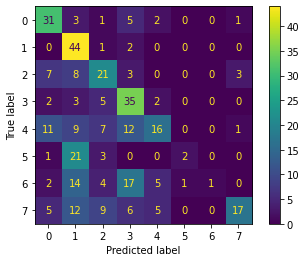

In [87]:
# Plot confustion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

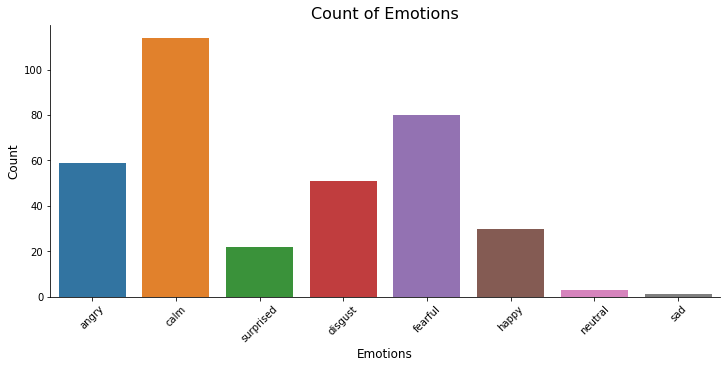

In [83]:
# Plot total count of predicted values
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(y_pred)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [84]:
# Get Accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
#- Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 46.39%


Citations:
- [How to Reshape Input Data for Long Short-Term Memory Networks in Keras](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/)
- [Speech Emotion Recognition.ipynb](https://www.kaggle.com/code/vidhuran07/speech-emotion-recognition-ipynb)
- [Working with Audio for first time](https://www.kaggle.com/code/fakhruddinkw/working-with-audio-for-first-time)
- [RAVDESS as .csv](https://www.kaggle.com/datasets/kartik2khandelwal/speech-emotion-dataset?select=features.csv)
- [RAVDESS Emotional song audio](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-song-audio)
- [Python Mini Project – Speech Emotion Recognition with librosa](https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/)
